In [ ]:
from __future__ import annotations
import numpy as np
from scipy.integrate import solve_ivp
from pathlib import Path

def _derivs(
    t: float,
    y: np.ndarray,
    m1: float,
    m2: float,
    L1: float,
    L2: float,
    g: float,
) -> list[float]:
    θ1, θ2, ω1, ω2 = y
    Δ = θ2 - θ1

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(Δ) ** 2
    den2 = (L2 / L1) * den1

    ω1_dot = (
        m2 * L1 * ω1**2 * np.sin(Δ) * np.cos(Δ)
        + m2 * g * np.sin(θ2) * np.cos(Δ)
        + m2 * L2 * ω2**2 * np.sin(Δ)
        - (m1 + m2) * g * np.sin(θ1)
    ) / den1

    ω2_dot = (
        -m2 * L2 * ω2**2 * np.sin(Δ) * np.cos(Δ)
        + (m1 + m2)
        * (g * np.sin(θ1) * np.cos(Δ) - L1 * ω1**2 * np.sin(Δ) - g * np.sin(θ2))
    ) / den2

    return [ω1, ω2, ω1_dot, ω2_dot]



def simulate_double_pendulum(
    t_max: float = 20.0,
    dt: float = 0.01,
    *,
    theta1_0: float = np.pi / 2,
    theta2_0: float = np.pi / 2,
    omega1_0: float = 0.0,
    omega2_0: float = 0.0,
    m1: float = 1.0,
    m2: float = 1.0,
    L1: float = 1.0,
    L2: float = 1.0,
    g: float = 9.81,
    atol: float = 1e-10,
    rtol: float = 1e-10,
) -> tuple[np.ndarray, np.ndarray]:

    y0 = [theta1_0, theta2_0, omega1_0, omega2_0]
    t_eval = np.arange(0.0, t_max + dt, dt)

    sol = solve_ivp(
        _derivs,
        t_span=(0.0, t_max),
        y0=y0,
        t_eval=t_eval,
        rtol=rtol,
        atol=atol,
        args=(m1, m2, L1, L2, g),
        method="DOP853",  
    )

    θ1, θ2, ω1, ω2 = sol.y
    sinθ1, cosθ1 = np.sin(θ1), np.cos(θ1)
    sinθ2, cosθ2 = np.sin(θ2), np.cos(θ2)
    Δ = θ2 - θ1
    sinΔ, cosΔ = np.sin(Δ), np.cos(Δ)

    T = (
        0.5 * m1 * (L1 * ω1) ** 2
        + 0.5
        * m2
        * (
            (L1 * ω1) ** 2
            + (L2 * ω2) ** 2
            + 2 * L1 * L2 * ω1 * ω2 * np.cos(Δ)
        )
    )
    V = -(m1 + m2) * g * L1 * np.cos(θ1) - m2 * g * L2 * np.cos(θ2)
    E = T + V

    X = np.column_stack(
        [
            sinθ1,
            cosθ1,
            sinθ2,
            cosθ2,
            ω1,
            ω2,
            sinΔ,
            cosΔ,
            ω2 - ω1,
            E,
        ]
    )

    return sol.t, X


def generate_and_save(
    out_path: str | Path = "double_pendulum.npz",
    **simulate_kwargs,
) -> None:
   
    t, X = simulate_double_pendulum(**simulate_kwargs)
    out_path = Path(out_path).expanduser()

    if out_path.suffix == ".npz":
        np.savez_compressed(out_path, t=t, X=X)
    elif out_path.suffix == ".csv":
        header = "t," + ",".join(
            [
                "sinθ1",
                "cosθ1",
                "sinθ2",
                "cosθ2",
                "ω1",
                "ω2",
                "sinΔ",
                "cosΔ",
                "Δω",
                "E",
            ]
        )
        data = np.column_stack([t, X])
        np.savetxt(out_path, data, delimiter=",", header=header, comments="")
    else:
        raise ValueError("Use a .npz or .csv extension for `out_path`.")



In [ ]:

import matplotlib.pyplot as plt

def plot_timeseries(
    t: np.ndarray,
    X: np.ndarray,
    *,
    show_energy: bool = True,
    feature_cols: list[int] | None = None,
    save_path: str | None = None,
) -> None:
   
    theta1 = np.arctan2(X[:, 0], X[:, 1])          
    theta2 = np.arctan2(X[:, 2], X[:, 3])
    omega1, omega2 = X[:, 4], X[:, 5]
    energy = X[:, 9]

    n_extra = len(feature_cols) if feature_cols else 0
    n_plots = 3 + n_extra if show_energy else 2 + n_extra

    fig, axes = plt.subplots(n_plots, 1, sharex=True, figsize=(8, 2.2 * n_plots))

    axes[0].plot(t, theta1, label="θ₁")
    axes[0].plot(t, theta2, label="θ₂")
    axes[0].set_ylabel("angle [rad]")
    axes[0].legend(loc="upper right")

    axes[1].plot(t, omega1, label="ω₁")
    axes[1].plot(t, omega2, label="ω₂")
    axes[1].set_ylabel("ω [rad s⁻¹]")
    axes[1].legend(loc="upper right")

    row = 2
    if show_energy:
        axes[row].plot(t, energy)
        axes[row].set_ylabel("E [J]")
        row += 1
        
    if feature_cols:
        for idx in feature_cols:
            axes[row].plot(t, X[:, idx], label=f"col {idx}")
        axes[row].set_ylabel("extra feat.")
        axes[row].legend(loc="upper right")

    axes[-1].set_xlabel("time [s]")
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150)
    else:
        plt.show()


In [ ]:

import matplotlib.pyplot as plt
import numpy as np


def plot_bob_paths(
    t: np.ndarray,
    X: np.ndarray,
    *,
    L1: float = 1.0,
    L2: float = 1.0,
    sample_rate: int = 1,
    mark_times: list[float] | None = None,
    save_path: str | None = None,
) -> None:
  
    idx = slice(None, None, sample_rate)

  
    theta1 = np.arctan2(X[:, 0], X[:, 1])  
    theta2 = np.arctan2(X[:, 2], X[:, 3])

    x1 = L1 * np.sin(theta1)[idx]
    y1 = -L1 * np.cos(theta1)[idx]

    x2 = x1 + L2 * np.sin(theta2)[idx]
    y2 = y1 - L2 * np.cos(theta2)[idx]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x1, y1, linewidth=0.8, label="first bob path")
    ax.plot(x2, y2, linewidth=0.8, label="second bob path")

    # pivot marker
    ax.scatter([0.0], [0.0], marker="o", color="k", zorder=3)

    # Optional time markers
    if mark_times:
        t_arr = np.asarray(t)
        for tm in mark_times:
            k = np.argmin(np.abs(t_arr - tm))
            ax.plot(
                L1 * np.sin(theta1[k]),
                -L1 * np.cos(theta1[k]),
                marker="o",
                color="C0",
            )
            ax.plot(
                L1 * np.sin(theta1[k]) + L2 * np.sin(theta2[k]),
                -L1 * np.cos(theta1[k]) - L2 * np.cos(theta2[k]),
                marker="o",
                color="C1",
            )

    ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title("Double-pendulum bob trajectories")
    ax.legend()

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150)
    else:
        plt.show()


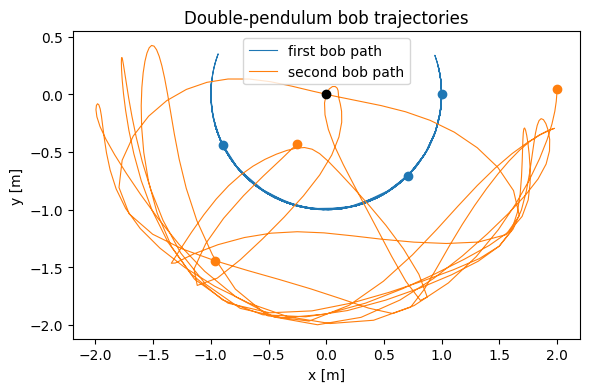

(1501, 10)


In [ ]:

t, X = simulate_double_pendulum(
    t_max=15,
    dt=0.01,
    theta1_0=np.pi/2,
    theta2_0=np.pi/2 + 0.05,
)


plot_bob_paths(t, X, L1=1.0, L2=1.0, sample_rate=5, mark_times=[0, 10, 20])

print(X.shape)

In [47]:
total = X.shape[0]


# training time (in time unit)
train_time  = 60.
# testing time (idem)
test_time   = 10.
# warmup time (idem): should always be > k * s
warm_time   = 60.

train_steps = round(total * train_time // (train_time + test_time + warm_time))
test_steps  = round(total * test_time // (train_time + test_time + warm_time))
warm_steps = round(total * warm_time // (train_time + test_time + warm_time))

from reservoirpy.nodes import Ridge, NVAR
nvar = NVAR(delay=1, order=2, strides=1) # 6 is good for order
readout = Ridge(10,ridge=1e-4, input_bias=False)

model = nvar >> readout

In [48]:
Xi_steps = int(train_steps + warm_steps)
Xi  = X[:Xi_steps-1]
dXi = X[1:Xi_steps] - X[:Xi_steps-1]

print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=int(warm_steps))

start_idx = int(warm_steps + train_steps - 2)
end_idx = int(warm_steps + train_steps)
nvar.run(X[start_idx:end_idx])
u = X[end_idx]
res = np.zeros((int(test_steps), readout.output_dim))
for i in range(int(test_steps)):
    u = u + model(u)
    res[i, :] = u

Xi shape: (1383, 10), dXi shape: (1383, 10)


Running Model-10: 1383it [00:00, 5297.90it/s]<?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Fitting node Ridge-10...


Running NVAR-10: 100%|██████████| 2/2 [00:00<00:00, 4341.93it/s]


predicted shape: (115, 10)
ground-truth shape: (108, 10)


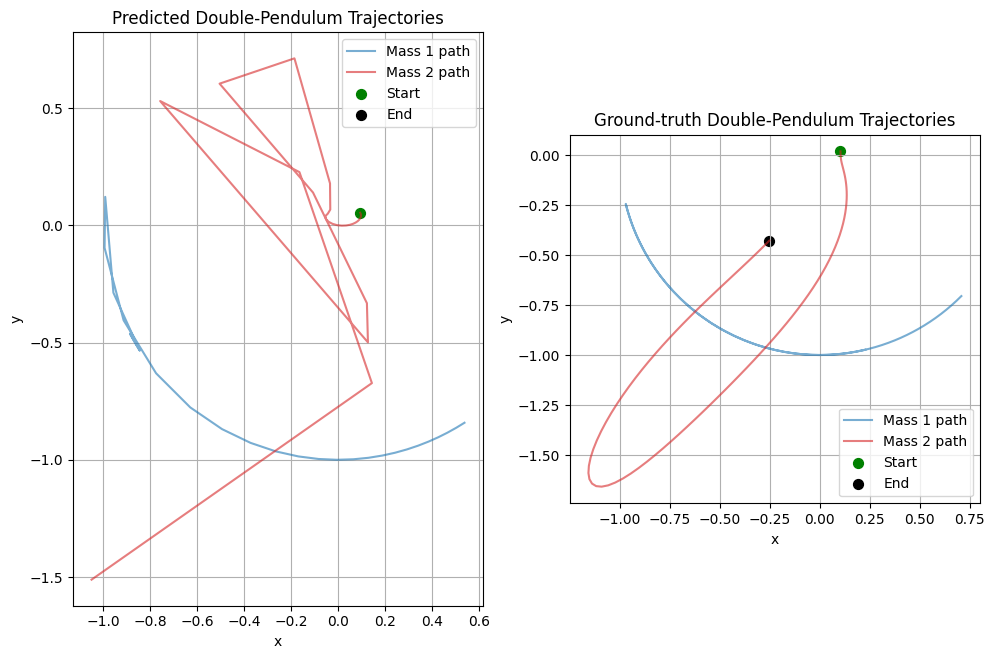

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

l1 = 1.0  
l2 = 1.0
idx_sinθ1, idx_cosθ1 = 0, 1
idx_sinθ2, idx_cosθ2 = 2, 3


def angles_to_xy(X: np.ndarray, l1: float, l2: float) -> tuple[np.ndarray, np.ndarray]:

    θ1 = np.arctan2(X[:, idx_sinθ1], X[:, idx_cosθ1])
    θ2 = np.arctan2(X[:, idx_sinθ2], X[:, idx_cosθ2])

    x1 = l1 * np.sin(θ1)
    y1 = -l1 * np.cos(θ1)

    x2 = x1 + l2 * np.sin(θ2)
    y2 = y1 - l2 * np.cos(θ2)
    return x1, y1, x2, y2


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121)
ax.set_title("Predicted Double-Pendulum Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")

x1_p, y1_p, x2_p, y2_p = angles_to_xy(res, l1, l2)
ax.plot(x1_p, y1_p, label="Mass 1 path", color="tab:blue", alpha=0.6)
ax.plot(x2_p, y2_p, label="Mass 2 path", color="tab:red",  alpha=0.6)
ax.scatter(x2_p[0],  y2_p[0],  s=50, color="green",  label="Start")
ax.scatter(x2_p[-1], y2_p[-1], s=50, color="black", label="End")
ax.set_aspect("equal")
ax.legend()
ax.grid(True)


ax2 = fig.add_subplot(122)
ax2.set_title("Ground-truth Double-Pendulum Trajectories")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

x1_t, y1_t, x2_t, y2_t = angles_to_xy(Y, l1, l2)
ax2.plot(x1_t, y1_t, label="Mass 1 path", color="tab:blue", alpha=0.6)
ax2.plot(x2_t, y2_t, label="Mass 2 path", color="tab:red",  alpha=0.6)
ax2.scatter(x2_t[0],  y2_t[0],  s=50, color="green",  label="Start")
ax2.scatter(x2_t[-1], y2_t[-1], s=50, color="black", label="End")
ax2.set_aspect("equal")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
print("predicted shape:", res.shape)
print("ground-truth shape:", Y.shape)
